In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
import scipy.optimize as sopt

from sklearn import datasets
from sklearn import metrics

In [9]:
from common.gradients import check_gradient, numerical_gradient, encode_params, decode_params

# Problem 3

IrisXFull is a (5, 150)-shaped matrix of float64
IrisX2feats is a (3, 150)-shaped matrix of float64
IrisY is a (1, 150)-shaped matrix of int64


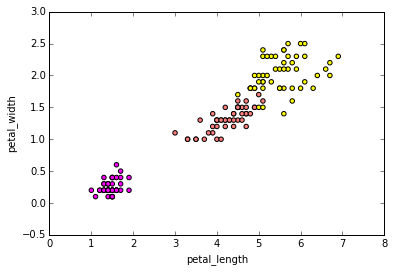

In [10]:
#
# Here we load the IRIS dataset.
# We will create two datasets: one using all features, and one using just Petal Langth and Petal Width for visualizations
#
iris = datasets.load_iris()
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisXFull = np.vstack([np.ones_like(petal_length), iris.data.T])
IrisX2feats = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
IrisY = iris.target.reshape(1,-1).astype(np.int64)

print "IrisXFull is a %s-shaped matrix of %s" % (IrisXFull.shape, IrisXFull.dtype)
print "IrisX2feats is a %s-shaped matrix of %s" % (IrisX2feats.shape, IrisX2feats.dtype)
print "IrisY is a %s-shaped matrix of %s" % (IrisY.shape, IrisY.dtype)

scatter(IrisX2feats[1,:], IrisX2feats[2,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')

In [89]:
def SoftMaxRegression_implementation(ThetaFlat, X, Y=None, return_probabilities=False, use_numerical_gradient=True):
    """
    Compute the outputs of a softmax classifier, or the loss and gradient
    
    Parameters
    ----------
    ThetaFlat : 
        flat array of parameters containing (n_features*n_classes) entries
    X :
        array of features, shape n_features x n_smaples
    Y :
        optional array of desired targets of shape 1 x n_samples
    return_probabilities : 
        if True, the probabilities are returned and Y is not used
        if False, the loss and gradient are computed on the X,Y pairs
    """
    #X is num_features x num_samples
    num_features, num_samples = X.shape

    #Theta is num_features x num_classes
    #we first reshape ThetaFlat into Theta
    Theta = ThetaFlat.reshape(num_features, -1)
    _, num_classes = Theta.shape

    #Activation of softmax neurons
    #A's shape should be num_classes x num_samples
    # TODO
    A = Theta.T.dot(X)
    #
    
    #Now compute the SoftMax function
    #O will be a num_classes x num_samples matrix of probabilities assigned by our model  
    #Stability optimization - for each subtract the maximum activation
    O = A - A.max(0, keepdims=True)
    #
    # TODO - compute SoftMax as vector O. Take the exp and normalize, so all values of O
    #        would sum to 1.0.
    def norm(x):
        e = exp(x)
        ret = e/e.sum()
        assert(abs(ret.sum() - 1.0) < 0.00001)
        return ret
    O = array([norm(o) for o in O.T]).T
    #O = norm(O)
    
    if return_probabilities:
        return O
    
    #The loss is the average per-sample nll (neg log likelihood)
    #The nll is the sum of the logarithms of probabilities assigned to each class
    Yr = Y.ravel()
    correct_class_likelihoods = np.log(O[Yr, np.arange(num_samples)])
    L = - 1.0/num_samples * np.sum(correct_class_likelihoods)

    #For the softmax activation and cross-entropy loss, the derivative dNLL/dA has a simple form
    #Please fill in its computation
    #
    # TODO
    def make_row(x):
        a = zeros(num_classes)
        a[x] = 1.
        return a
    Yi_is_k = array([make_row(x) for x in Yr]).T
    dLdA1 = array([[O[k,i] - (1. if Yr[i] == k else 0.) for i in range(num_samples)] for k in range(num_classes)])
    #
    dLdA2 = O - Yi_is_k
    dLdA = dLdA1

    #Now we compute the gradient of the loss with respect to Theta
    dLdTheta = np.dot(X, dLdA.T)
    
    if use_numerical_gradient:
        dLdTheta = numerical_gradient(
            lambda T: SoftMaxRegression_implementation(T, X, Y, use_numerical_gradient=False),
            ThetaFlat)

    #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
    return L, dLdTheta.reshape(ThetaFlat.shape)

#Make a function for training on irises
iris_log_reg_cost = lambda Theta: SoftMaxRegression_implementation(Theta, IrisXFull, IrisY, False)
#Make sure that the gradient computation is OK
check_gradient(iris_log_reg_cost, np.zeros((3*5,)))
check_gradient(iris_log_reg_cost, np.random.rand(3*5)*2.0-1.0)

True

In [90]:
#
# Call a solver
#

#iprint will cause the solver to print TO THE TERMINAL from which ipython notebook was started
ThetaOpt = sopt.fmin_l_bfgs_b(iris_log_reg_cost, np.zeros((3*5,)), iprint=1)[0]

check_gradient(iris_log_reg_cost, ThetaOpt)

True

In [91]:
#
# Compute training errors
#

probabilities = SoftMaxRegression_implementation(ThetaOpt, IrisXFull, return_probabilities=True)
predictions = np.argmax(probabilities,0)

print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 98.666667%


In [121]:
#
# Now redo the training for two features
#
# TODO - again, use l_bfgs to find optimal theta, then compute probabilities and new predictions.
iris2_log_reg_cost = lambda Theta: SoftMaxRegression_implementation(Theta, IrisX2feats, IrisY, False)
#Make sure that the gradient computation is OK
check_gradient(iris_log_reg_cost, np.zeros((3*5,)))
check_gradient(iris_log_reg_cost, np.random.rand(3*5)*2.0-1.0)
Theta2class = sopt.fmin_l_bfgs_b(iris2_log_reg_cost, np.zeros((3*5,)), iprint=1)[0]

check_gradient(iris_log_reg_cost, ThetaOpt)

probabilities2 = SoftMaxRegression_implementation(Theta2class, IrisX2feats, return_probabilities=True)
predictions2 = np.argmax(probabilities2,0)
#


print "Training accurracy: %f%%" % ((predictions2==IrisY.ravel()).mean()*100)

Training accurracy: 96.000000%


In [122]:
#
# Now plot the decision boundary
# 

petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2feats[1,:].min(), IrisX2feats[1,:].max(), 100),
                                          np.linspace(IrisX2feats[2,:].min(), IrisX2feats[2,:].max(), 100))

IrisXGrid = np.vstack([np.ones(np.prod(petal_lengths.shape)), petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = SoftMaxRegression_implementation(Theta2class, IrisXGrid, return_probabilities=True).argmax(0)

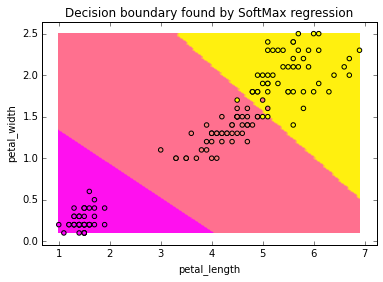

In [123]:
contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(IrisX2feats[1,:], IrisX2feats[2,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by SoftMax regression')

# Problem 4

Please note, that we **move the addition of the bias term** into the network implementation! Please note, that typically instead of changing the inputs we keep another vector of bias terms.

In [168]:
def TwoLayerNet_implementation(
    ThetaFlat,
    ThetaShapes,
    X,
    Y=None,
    return_probabilities=False,
    use_numerical_gradient=True,
    return_hidden = False):
    """
    Compute the outputs of a softmax classifier, or the loss and gradient
    
    Parameters
    ----------
    ThetaFlat : 
        flat array of parameters
    ThetaShapes :
        list of shapes of weight and bias matrices
    X :
        array of features, shape n_features x n_smaples
    Y :
        optional array of desired targets of shape 1 x n_samples
    return_probabilities : 
        if True, the probabilities are returned and Y is not used
        if False, the los and gradient is computed on the X,Y pairs
    """
    #X is num_features x num_samples
    num_features, num_samples = X.shape

    #Extract weight matrices
    W1, W2 = decode_params(ThetaFlat, ThetaShapes)
    
    X_padded = np.vstack([np.ones((1, num_samples)), X])
    
    #Activation in first layer. Shape is num_hidden x num_samples
    #
    # TODO
    A1 = W1.T.dot(X_padded) 

    #Apply the transfer function
    #
    # TODO
    H1 = tanh(A1)
    #
        
    #Pad with zeros
    H1_padded = np.vstack([np.ones((1, num_samples)), H1])
    
    #Now apply the second linear transform
    #
    # TODO
    A2 = W2.T.dot(H1_padded) 
    #
    
    #Now compute the SoftMax function
    #O will be a num_classes x num_samples matrix of probabilities assigned by our model  
    #Stability optimization - for each subtract the maximum activation
    O = A2 - A2.max(0, keepdims=True)
    # 
    # TODO - compute SoftMax as vector O. Take the exp and normalize, so all values of O
    #        would sum to 1.0.
    def norm(x):
        e = exp(x)
        ret = e/e.sum()
        assert(abs(ret.sum() - 1.0) < 0.00001)
        return ret
    O = array([norm(o) for o in O.T]).T

    if return_hidden:
        return H1

    if return_probabilities:
        return O
    
    #The loss is the average per-sample nll (neg log likelihood)
    #The nll is the sum of the logarithms of probabilities assigned to each class
    correct_class_likelihoods = np.log(O[Y.ravel(), np.arange(num_samples)])
    L = - 1.0/num_samples * np.sum(correct_class_likelihoods)

    #For the softmax activation and cross-entropy loss, the derivative dNLL/dA has a simple form
    #Please fill in its computation
    #
    # TODO
    num_classes = W2.shape[1]
    def make_row(x):
        a = zeros(num_classes)
        a[x] = 1.
        return a
    dLdA2 =  O - array([make_row(x) for x in Y.ravel()]).T
    #

    dLdH1_padded = W2.dot(dLdA2)
    dLdH1 = dLdH1_padded[1:,:] #ship the derivatives backpropagated to the added ones
    
    #
    # TODO - compute the derivatives dLdW2 and dLdW1
    # Hint - to compute dLdW1, start with dLdA1
    #
    dLdThetaFlat = zeros_like(O)
    if use_numerical_gradient:
        dLdThetaFlat = numerical_gradient(
            lambda T: TwoLayerNet_implementation(T, ThetaShapes, X, Y, use_numerical_gradient=False),
            ThetaFlat).reshape(ThetaFlat.shape)
    # dLdThetaFlat, unused_shapes = encode_params([dLdW1, dLdW2])
    
    #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
    return L, dLdThetaFlat

# Problem 5

In [110]:
#
# Here we init the network for gradient testing on IRIS
#
# We will have 7 hidden neurons.
# The first weight matrix will be 5 (4 features + bias) x 7 (hidden neurons)
# The second weight matrix will be 8 (7 neurons + bias) x 3 (classes)
#
num_hidden = 7
#
# TODO
W1 = rand(5, num_hidden) * 0.2
W2 = rand(num_hidden + 1, 3) * 0.2
#

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

#Make a function for training on irises
iris_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, iris.data.T, IrisY, False)
#Make sure that the gradient computation is OK
check_gradient(iris_net_cost, Theta0)
check_gradient(iris_net_cost, np.zeros_like(Theta0))
check_gradient(iris_net_cost, np.ones_like(Theta0)*0.01)

True

In [111]:
#
# TODO - apply L-BFGS to minimize the loss and get optimal ThetaOpt.
ThetaOpt = sopt.fmin_l_bfgs_b(iris_net_cost, Theta0, iprint=1)[0]

check_gradient(iris_net_cost, ThetaOpt)
#
predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, iris.data.T, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 99.333333%


# Problem 6

Please note - we will act as if we had two classes. Thus we will use the softmax output of the network

In [113]:
XOR2X = np.array([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).T
XOR2Y = np.array([[0,1,1,0]])

In [173]:
#init the neurons
num_hidden = 2
W1 = (np.random.rand(3,num_hidden) - 0.5)
W2 = (np.random.rand(num_hidden+1,2) -0.5)

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

#
# TODO - apply L-BFGS to minimize the loss and get optimal ThetaOpt.
#Make a function for training on irises
xor_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape,  XOR2X, XOR2Y, False)
#Make sure that the gradient computation is OK
check_gradient(xor_net_cost, Theta0)
check_gradient(xor_net_cost, np.zeros_like(Theta0))
check_gradient(xor_net_cost, np.ones_like(Theta0)*0.01)
ThetaOpt = sopt.fmin_l_bfgs_b(xor_net_cost, Theta0, iprint=1)[0]
#

TwoLayerNet_implementation(ThetaOpt, ThetaShape, XOR2X, return_probabilities=True).argmax(0)

array([0, 1, 1, 0])

In [174]:
#
# TODO - repeat the experiment for 3-dimensional XOR.
XOR3X = np.array([[0,0,0],
                  [0,1,0],
                  [1,0,0],
                  [1,1,0],
                  [0,0,1],
                  [0,1,1],
                  [1,0,1],
                  [1,1,1]]).T
XOR3Y = np.array([[0,1,1,0,1,0,0,1]])
#init the neurons
num_hidden = 3
W1 = (np.random.rand(4,num_hidden) - 0.5)
W2 = (np.random.rand(num_hidden+1,2) -0.5)

# Now flatten into an array
Theta0, ThetaShape3 = encode_params([W1,W2])

#
# TODO - apply L-BFGS to minimize the loss and get optimal ThetaOpt.
#Make a function for training on irises
xor_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape3,  XOR3X, XOR3Y, False)
#Make sure that the gradient computation is OK
check_gradient(xor_net_cost, Theta0)
check_gradient(xor_net_cost, np.zeros_like(Theta0))
check_gradient(xor_net_cost, np.ones_like(Theta0)*0.01)
ThetaOpt3 = sopt.fmin_l_bfgs_b(xor_net_cost, Theta0, iprint=1)[0]
#

In [175]:
TwoLayerNet_implementation(
    ThetaOpt3,
    ThetaShape3,
    XOR3X,
    return_probabilities=True).argmax(0)
#

array([0, 1, 1, 0, 1, 0, 0, 1])

In [176]:
#
# (Bonus)
# TODO - change network implementation code to return hidden activations.
# Hint - locals() gives the dictionary of all objects in a functions's scope!
#
h1, h2 = TwoLayerNet_implementation(
    ThetaOpt,
    ThetaShape,
    XOR2X,
    return_hidden=True)
#SoftMaxRegression_implementation(h1, XOR3X, return_probabilities=True)
h1

array([-1.        , -1.        ,  1.        , -0.99999522])

In [189]:
xor_x, xor_y = np.meshgrid(np.linspace(-0.5, 1.5, 100),
                           np.linspace(-0.5, 1.5, 100))

XorXGrid = np.vstack([xor_x.ravel(), xor_y.ravel()])
h1_grid, h2_grid = TwoLayerNet_implementation(ThetaOpt, ThetaShape, XorXGrid, return_probabilities=True)

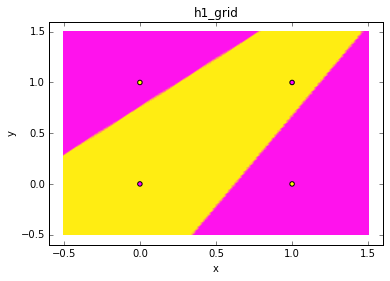

In [193]:
contourf(xor_x, xor_y, h1_grid.reshape(xor_x.shape), cmap='spring')
scatter(XOR2X[0,:], XOR2X[1,:], c=XOR2Y.ravel(), cmap='spring')
xlabel('x')
ylabel('y')
title('h1_grid')

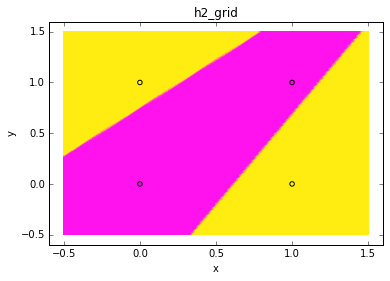

In [194]:
contourf(xor_x, xor_y, h2_grid.reshape(xor_x.shape), cmap='spring')
scatter(XOR2X[0,:], XOR2X[1,:], c=XOR2Y.ravel(), cmap='spring')
xlabel('x')
ylabel('y')
title('h2_grid')

# Problem 7

In [203]:
IrisNormX = np.array(iris.data.T)
#
# TODO - normalize IrisNormX, so the vlaues would fall into [-1,1].
#        Avoid looping constructs.
#
IrisNormX = IrisNormX - IrisNormX.min()
IrisNormX = IrisNormX / IrisNormX.max() * 2.
IrisNormX = IrisNormX - 1.
IrisNormX.min(), IrisNormX.max()

(-1.0, 1.0)

In [206]:
num_hidden = 10

W1 = (np.random.rand(5, num_hidden) - 0.5)*0.1
W2 = (np.random.rand(num_hidden + 1, 3) - 0.5)*0.1

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1, W2])

#
# TODO - cripple and train your neural network.
#
iris_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, IrisNormX, IrisY, False)
ThetaOpt = sopt.fmin_l_bfgs_b(iris_net_cost, Theta0, iprint=1)[0]

predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, IrisNormX, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 99.333333%
